In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from collections import Counter, OrderedDict

In [2]:
from scipy.spatial.distance import cosine
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer

In [3]:
from tqdm.auto import tqdm
from dataclasses import dataclass
import re
from random import random
import random as random

In [5]:
files = ['interview_ds.txt', 'interview_ds_2.txt']
path = "/content/drive/MyDrive/24_7 data/"

In [4]:
def get_data():
    with open(f"{path}{files[0]}", 'r') as f:
      file1 = f.readlines()

    with open(f"{path}{files[1]}", 'r') as f:
      file2 = f.readlines()

    final_corpus = file1 + file2
    index = int(0.9*len(final_corpus))
    train_iter , valid_iter= final_corpus[:index], final_corpus[index:]
    return train_iter, valid_iter

In [6]:
@dataclass
class Word2VecParams:

    # skipgram parameters
    MIN_FREQ = 50
    SKIPGRAM_N_WORDS = 7
    T = 1e-3
    NEG_SAMPLES = 10
    NS_ARRAY_LEN = 5_000_000
    SPECIALS = ""
    TOKENIZER = 'basic_english'

    # network parameters
    BATCH_SIZE = 64
    EMBED_DIM = 64
    EMBED_MAX_NORM = None
    N_EPOCHS = 4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CRITERION = nn.BCEWithLogitsLoss()

In [80]:
from torch._C import Value
class Vocab:

  def __init__(self, tokens, specials):
    self.stoi = {v[0] :(k, v[1]) for k,v in enumerate(tokens)}
    self.itos = {k:(v[0], v[1]) for k,v in enumerate(tokens)}

    self._specials = specials[0]
    self.total_tokens = np.nansum([f for _, (_, f) in self.stoi.items()], dtype=int)


  def __len__(self):
    return len(self.stoi) - 1

  def get_index(self, word):

    if word in self.stoi:
      return self.stoi.get(word)[0]
    else:
      raise ValueError(f"Word/phrase: {word} not a word or phrase")


  def get_freq(self, word):

    if word in self.stoi:
      return self.stoi.get(word)[1]
    else:
      raise ValueError(f"Word/phrase: {word} not a word or phrase")

  def lookup_token(self, token):

    if token in self.itos:
      return self.itos.get(token)[0]

    else:

      raise ValueError(f"out of index")

In [81]:
def token_generator(iterator, tokenizer):

  r = re.compile('[a-z1-9]')
  for text in iterator:

    res = tokenizer(text)
    res = list(filter(r.match, res))
    yield res

def build_vocab(iterator, tokenizer, params, min_freq = 1, max_tokens=None):

  counter = Counter()

  for tokens in tqdm(token_generator(iterator, tokenizer)):
    counter.update(tokens)

  counter = sorted(counter.items(), key = lambda x:(-x[1], x[0]))

  word_freq = OrderedDict(counter)

  tokens = []
  for token, f in word_freq.items():
    if f >=min_freq:
      tokens.append((token, f))


  word_vocab = Vocab(tokens, specials=[params.SPECIALS, np.nan])

  return word_vocab

In [42]:
from sklearn.preprocessing import normalize

In [147]:
class Model(nn.Module):

  def __init__(self, vocab, params) -> None:
    super().__init__()
    self.vocab = vocab

    self.embeds =  nn.Embedding(self.vocab.__len__()+1,
                                      params.EMBED_DIM, max_norm=params.EMBED_MAX_NORM)
    self.context_embeds =  nn.Embedding(self.vocab.__len__()+1,
                                      params.EMBED_DIM, max_norm=params.EMBED_MAX_NORM)

  def forward (self, inputs, context):

    target_embeddings = self.embeds(inputs)
    target_embeddings = torch.unsqueeze(target_embeddings, dim=1) # shape: Bx1xE

    context_embeddings = self.context_embeds(context)
    context_embeddings = context_embeddings.permute(0, 2, 1) # transpose for batch multiplication

    out = torch.bmm(target_embeddings, context_embeddings)
    out = out.view(out.shape[0], out.shape[2])

    return out

  def normalize_embeddings(self):
    embeddings = list(self.embeds.parameters())[0]
    embeddings = embeddings.cpu().detach().numpy()
    self.norm_embeddings = normalize(embeddings)

    return self.norm_embeddings


  def get_similar_words(self, word, n=5):

    embeddings = self.normalize_embeddings()
    word_ind = self.vocab.get_index(word)

    dot_products = np.matmul(embeddings, embeddings[word_ind]).flatten()
    top_n = np.argsort(-dot_products)[1 : n + 1]

    results = []
    for index in top_n:
      results.append((self.vocab.lookup_token(index), dot_products[index]))

    return results

  def get_analogy(self, word, analogy, target_word, n=5):

    # analogical reasoning task , analogies such as “Germany” : “Berlin” :: “France” : ? ans:"Paris"
    # vec(“Berlin”) - vec(“Germany”) + vec(“France”)

    embeddings = self.normalize_embeddings()
    relation = embeddings[self.vocab.get_index(word)] - \
    embeddings[self.vocab.get_index(analogy)] + embeddings[self.vocab.get_index(target_word)]

    dot_products = np.matmul(embeddings, relation).flatten()
    top_n = np.argsort(-dot_products)[1 : n + 1]

    results = []
    for index in top_n:
      results.append((self.vocab.lookup_token(index), dot_products[index]))

    return results


In [148]:
state_dict = torch.load("word2vec_2.pth", map_location=torch.device('cpu'))

In [149]:
params = Word2VecParams()
train_iter, valid_iter = get_data()
tokenizer = get_tokenizer(params.TOKENIZER)
vocab = build_vocab(train_iter+valid_iter, tokenizer, params)

0it [00:00, ?it/s]

In [83]:
len(vocab)

14039

In [150]:
model = Model(vocab, params)

In [151]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
counter = sorted(vocab.stoi.items(), key = lambda v: v[1][1])

In [25]:
counts = [v[1][1] for v in counter]

# **Word Count Histogram**

<Axes: >

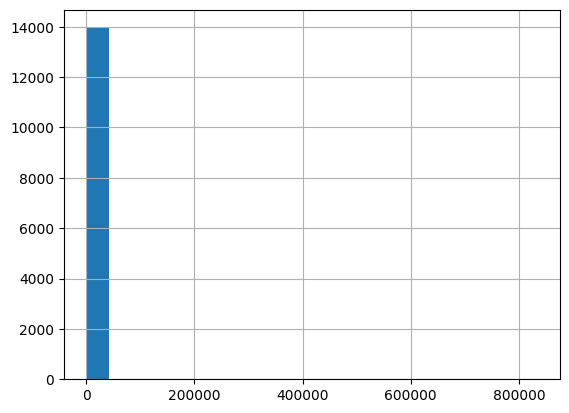

In [26]:
pd.Series(counts).hist(bins=20)

**As can be seen most of words in the vocabulary have a count less than 100. Lets  look at the histogram counts where counts for various ranges**

**when counts < 100**

<Axes: >

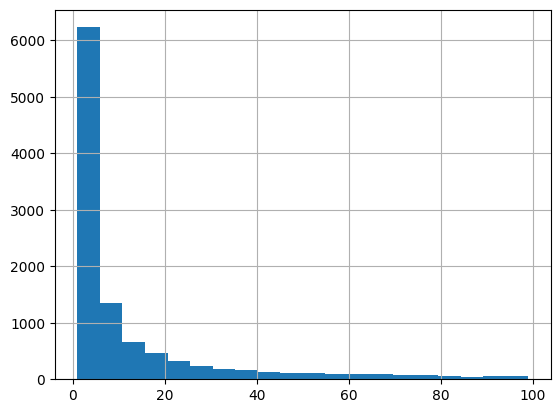

In [33]:
counts = pd.Series(counts)

counts.loc[counts<100].hist(bins=20)

In [159]:
len(counts.loc[counts == 1])

3266

**when counts > 100 and counts <=10000**

<Axes: >

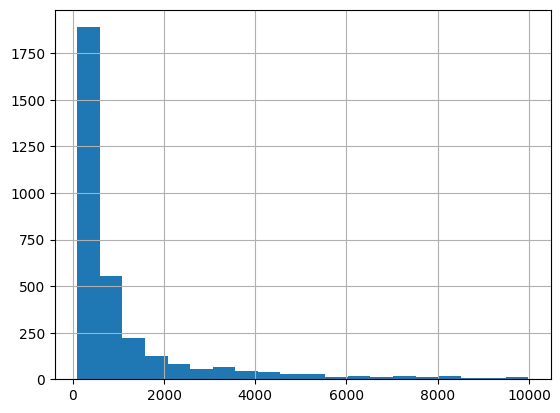

In [35]:
counts.loc[(counts>=100)&(counts<=10000)].hist(bins=20)

**counts >10000**

<Axes: >

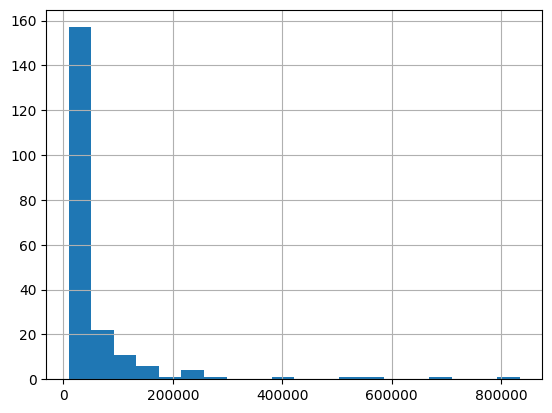

In [38]:
counts.loc[(counts>10000)].hist(bins=20)

**lets look at the words with very high counts**

```
# This is formatted as code
```



In [117]:
print(sorted(vocab.stoi.items(), key = lambda v: -v[1][1]) [:20])

[('the', (0, 833516)), ('and', (1, 678137)), ('to', (2, 555648)), ('a', (3, 543555)), ('was', (4, 391267)), ('she', (5, 262987)), ('he', (6, 254659)), ('it', (7, 251852)), ('they', (8, 246987)), ('her', (9, 225202)), ('lily', (10, 193492)), ('day', (11, 157142)), ('with', (12, 149212)), ('said', (13, 148892)), ('his', (14, 147392)), ('in', (15, 135190)), ('that', (16, 133920)), ('but', (17, 116605)), ('s', (18, 111434)), ('you', (19, 110824))]


**These are mostly common verbs, adjectives and adverbs, used allover the text**

**Now lets look at few word embedding plots**

---



In [78]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [120]:
embeddings = model.normalize_embeddings()

In [67]:
counter = sorted(vocab.stoi.items(), key = lambda v: -v[1][1])
word_freq = OrderedDict(counter)


In [74]:
print(list(word_freq.items())[100:500])

[('want', (100, 26780)), ('home', (101, 26316)), ('make', (102, 25324)), ('got', (103, 25102)), ('made', (104, 24982)), ('out', (105, 24769)), ('away', (106, 24394)), ('see', (107, 24373)), ('smiled', (108, 24300)), ('toys', (109, 24253)), ('some', (110, 24052)), ('outside', (111, 23937)), ('again', (112, 23696)), ('sue', (113, 23302)), ('around', (114, 22846)), ('always', (115, 22388)), ('because', (116, 22180)), ('find', (117, 22174)), ('something', (118, 22170)), ('good', (119, 22082)), ('let', (120, 21976)), ('put', (121, 21658)), ('scared', (122, 21501)), ('things', (123, 21488)), ('liked', (124, 21358)), ('down', (125, 21048)), ('thought', (126, 20951)), ('my', (127, 20786)), ('ran', (128, 20724)), ('who', (129, 20656)), ('took', (130, 20122)), ('about', (131, 19947)), ('ben', (132, 19938)), ('man', (133, 19391)), ('me', (134, 19263)), ('car', (135, 19125)), ('told', (136, 18858)), ('house', (137, 18724)), ('sam', (138, 18722)), ('after', (139, 18702)), ('spot', (140, 18669)), ('

In [109]:
indexes = random.choices(range(100, 10000), k=200)

In [121]:
tsne = TSNE(2)

In [122]:
plotx = tsne.fit_transform(embeddings[indexes])

In [123]:
labels = [vocab.lookup_token(x) for x in indexes]

In [124]:
len(labels)

200

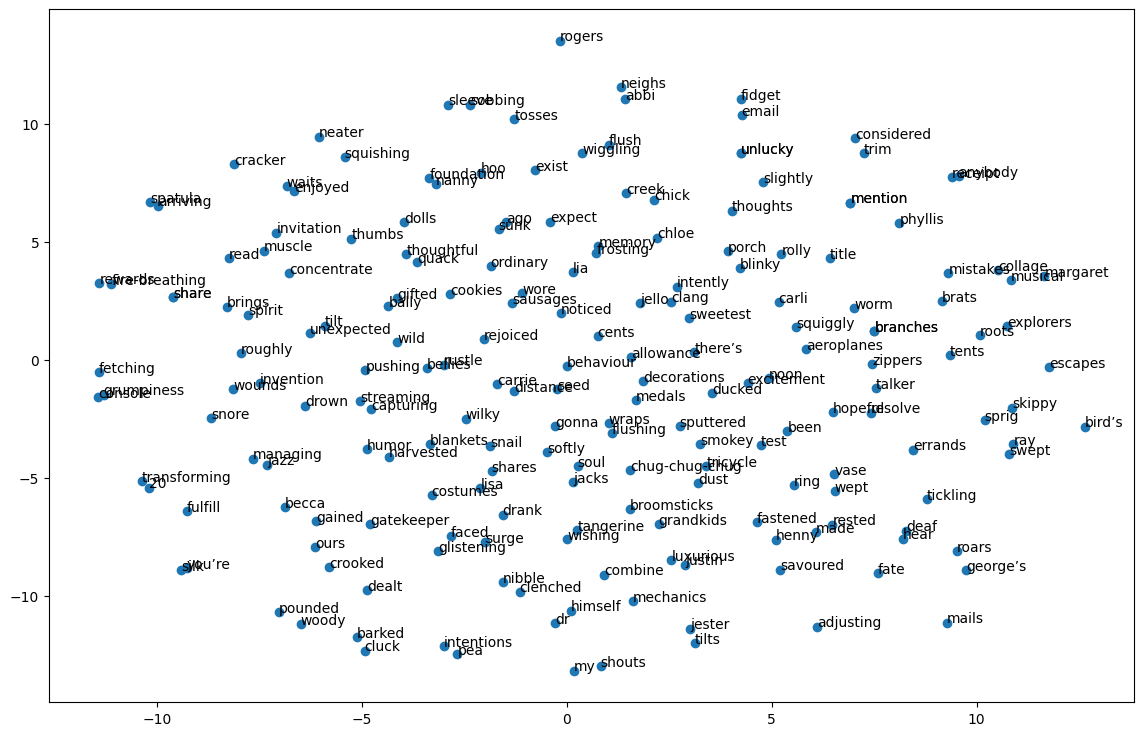

In [125]:
plt.figure(figsize=(14,9))
plt.scatter(plotx[:,0], plotx[:,1])
for i in range(plotx.shape[0]):
    plt.annotate(labels[i], (plotx[i][0], plotx[i][1]))
plt.show()

**Now lets look at some word similarity**

In [135]:
model.get_similar_words('food', 10)

['quiz',
 'cheese',
 'animal',
 'disappoint',
 'snack',
 'dumped',
 'apples',
 'habits',
 'neatly',
 'cook']

In [137]:
model.get_similar_words('chocolate', 10)

['cocoa',
 'drink',
 'ingredients',
 'butter',
 'cookies',
 'soup',
 'treat',
 'bowl',
 'wound',
 'sugar']

In [140]:
model.get_similar_words('love', 10)

['welcome',
 'thank',
 'm',
 'are',
 'have',
 'will',
 'you',
 'sorry',
 'smiles',
 'thanks']

In [141]:
model.get_similar_words('animal', 10)

['leopard',
 'cheerful',
 'zoo',
 'food',
 'mouse',
 'the',
 'min',
 'ollie',
 'lucy',
 'mimi']

In [142]:
model.get_similar_words('dolls', 10)

['dress-up',
 'bears',
 'cars',
 'with',
 'pictures',
 'especially',
 'teddy',
 'bear',
 'toys',
 'books']

In [143]:
model.get_similar_words('lion', 10)

['brave',
 'fox',
 'tim',
 'leo',
 'rabbit',
 'monkey',
 'bobo',
 'freddy',
 'monster',
 'frog']

In [155]:
model.get_analogy('prince', 'princess', 'boy', 10)

['friends',
 'ducky',
 'above',
 'brave',
 'heel',
 'pigeon',
 'task',
 'problem',
 'ending',
 'little']

In [158]:
model.get_similar_words('king', 10)

['castle',
 'near',
 'cage',
 'ollie',
 'cow',
 'poor',
 'protect',
 'jealous',
 'elephant',
 'value']